## Project 1: Classification of ENSO extreme phases through SST data

## Data read + plotting NINO3.4

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['font.size'] = 12

Text(0, 0.5, 'NINO3.4')

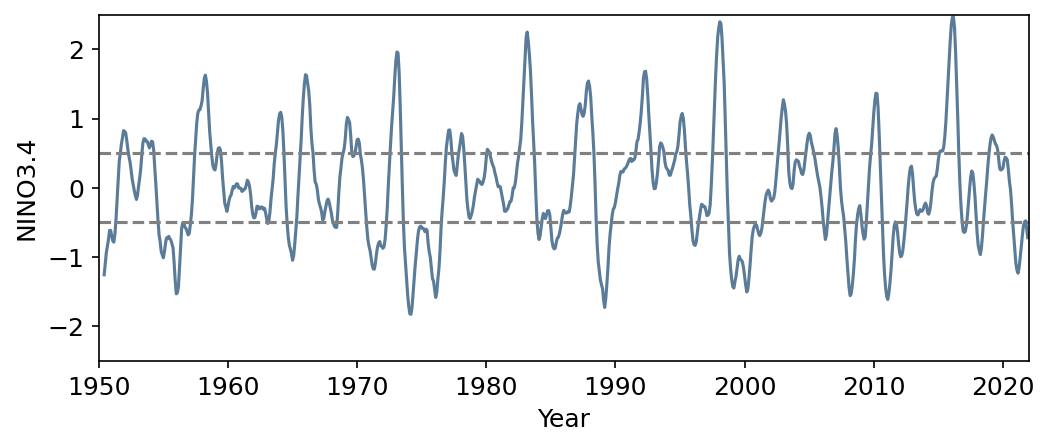

In [2]:
#path = r '/Users/areti/OneDrive/Desktop/UU/block_4/Advanced_topics/ATCD_myrep/ATCD_2025_UU/'
filename ="ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc"
sstds = xr.open_dataset(filename)
sst = sstds.sst
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.xlabel("Year")
plt.ylabel("NINO3.4")
#plt.show()

In [3]:
elnino_idx = np.where(nino34>0.5)
lanina_idx = np.where(nino34< -0.5)
events_idx = np.where((nino34> 0.5) | (nino34< -0.5))

In [4]:
elnino = sst[elnino_idx]
lanina = sst[lanina_idx]

In [5]:
events = sst[events_idx]

In [6]:
data= sstds
#data = data.sst.fillna(0)
Nino34 = xr.DataArray(nino34, dims=('time'), name='nino34')
timevec = xr.DataArray(timevec, dims=('time'), name='timevec')
class_bin = xr.DataArray(np.full(nino34.shape, np.nan), dims=('time'), name='class')
# Add it to the dataset
data["timevec"] = timevec
data["nino34"] = Nino34
data["class"] = class_bin
data["class"][elnino_idx] = 1
data["class"][lanina_idx] = 0 
data= data.dropna(dim='time', subset=['class'])
data

<xarray.Dataset> Size: 59MB
Dimensions:  (time: 464, lat: 89, lon: 180)
Coordinates:
  * time     (time) object 4kB 1950-06-01 00:00:00 ... 2021-12-15 00:00:00
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float64 59MB ...
    timevec  (time) float64 4kB 1.95e+03 1.95e+03 ... 2.022e+03 2.022e+03
    nino34   (time) float64 4kB -1.255 -1.09 -0.9358 ... -0.5526 -0.5814 -0.7192
    class    (time) float64 4kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

# Identify El Nino and La Nina events and create a binary class

### Split data into training, validation and testing datasets

In [7]:
training = data.sel(time=(data.time.dt.year >= 1950) & (data.time.dt.year <= 2000))
validation = data.sel(time=(data.time.dt.year > 2000) & (data.time.dt.year <= 2010))
testing = data.sel(time=(data.time.dt.year > 2010) & (data.time.dt.year <= 2021))

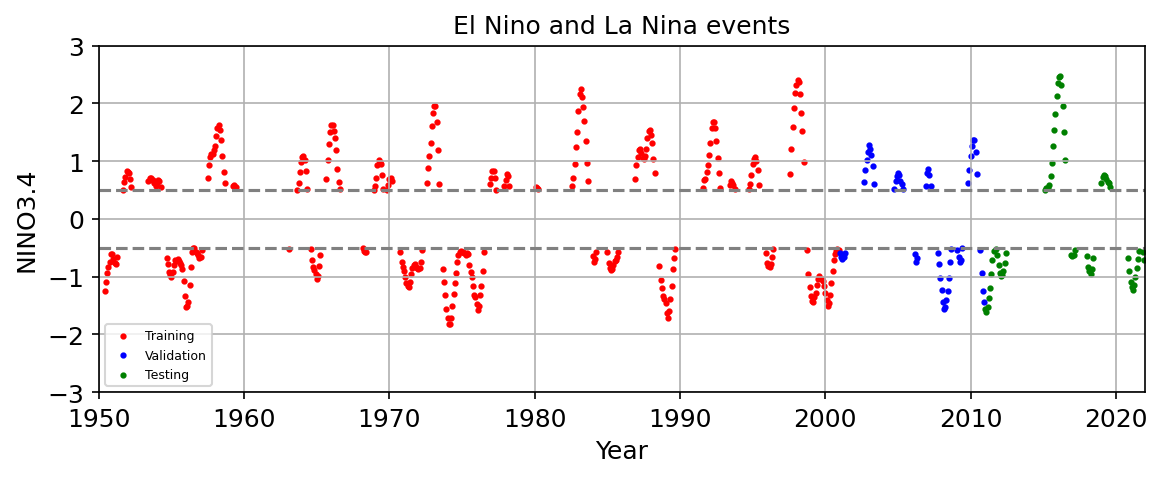

In [8]:
plt.figure(figsize=(9,3))
#training.nino34.plot()
plt.title('El Nino and La Nina events', fontsize =12)
plt.scatter(training.timevec,training.nino34.values,color='red', label = 'Training', s =4)
plt.scatter(validation.timevec,validation.nino34.values,color='blue', label = 'Validation', s =4)
plt.scatter(testing.timevec,testing.nino34,color='green', label = 'Testing', s =4)
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.legend(loc = 'lower left', fontsize =6)
plt.ylim(-3,3)
plt.grid()
plt.xlabel("Year")
plt.ylabel("NINO3.4")
plt.savefig(f'Elnino.png',bbox_inches='tight',dpi=150, format='png')

### Standartize the sst data

In [9]:
def stand(dataset, ref_data ):
    
    sd   = ref_data.sst.std('time')
    mean = ref_data.sst.mean('time')
    stand = (dataset.sst - mean)/sd
    stand = stand.fillna(0)
    
    return stand  

In [10]:
training_sd   = stand(training,training)
validation_sd = stand(validation,training)
testing_sd    = stand(testing,training)

C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Prepare the data for the neural network 

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional


In [12]:
training_sd.values.shape

(340, 89, 180)

In [13]:
def prep_data(ds):
    ds =  ds.values 
    ds_flat = ds.reshape(ds.shape[0], ds.shape[1] * ds.shape[2])
    return ds_flat 

In [14]:
dataset = prep_data(training_sd)
valid_ds = prep_data(validation_sd)
test_ds = prep_data(testing_sd)
dataset.shape

(340, 16020)

In [15]:
class_labels = training['class'].values

In [16]:
class_labels.shape

(340,)

In [17]:
class customDataset(Dataset):
    def __init__(self,data,labels):
        self.data=data
        self.labels=labels
    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]
    def __len__(self):
        return self.data.shape[0]


### Training dataset 

In [18]:
#turn to torch 
data=torch.from_numpy(dataset).to(torch.float32)
labels=torch.from_numpy(class_labels).long()
labels=functional.one_hot(labels).to(torch.float32)
#training data loader 
custom_dataset=customDataset(data,labels)

#We split our data into batches 
Data_loader=DataLoader(custom_dataset, batch_size= 32 ,shuffle=False)
for x,y in Data_loader:
    print(x.shape)
    print(y.shape)
    

torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([32, 16020])
torch.Size([32, 2])
torch.Size([20, 16020])
torch.Size([20, 2])


In [19]:
idx=0
print("total length dataset:{}".format(custom_dataset.__len__()))
print("{}th element in the dataset is:{}".format(idx,custom_dataset.__getitem__(idx)[0]))
print("with corresponding label:{}".format(custom_dataset.__getitem__(idx)[1]))

total length dataset:340
0th element in the dataset is:tensor([0., 0., 0.,  ..., 0., 0., 0.])
with corresponding label:tensor([1., 0.])


### Validation dataset 

In [20]:
class_labels_val = validation['class'].values

valid_data=torch.from_numpy(valid_ds).to(torch.float32)
labels_val=torch.from_numpy(class_labels_val).long()
labels_val=functional.one_hot(labels_val).to(torch.float32)

custom_dataset_val=customDataset(valid_data,labels_val)
Data_loader_val=DataLoader(custom_dataset_val,batch_size=32,shuffle=False)
#labels_val

### Test dataset

In [21]:
class_labels_test = testing['class'].values

test_data=torch.from_numpy(test_ds).to(torch.float32)
labels_test=torch.from_numpy(class_labels_test).long()
labels_test=functional.one_hot(labels_test).to(torch.float32)

custom_dataset_test=customDataset(test_data,labels_test)
Data_loader_test=DataLoader(custom_dataset_test,batch_size=32,shuffle=False)
#labels_val

# Define Freedworward Neural Network

In [22]:
# Device configuration
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

device = "coda" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")

seed =42

Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cpu


In [23]:
# Archotecture of Freedforward Neural Network
from torch import nn
import random

torch.manual_seed(seed)                 # CPU seed
torch.cuda.manual_seed(seed)            # GPU seed (if using CUDA)
torch.cuda.manual_seed_all(seed)        # all GPUs
np.random.seed(seed)                     # NumPy seed
random.seed(seed)                        # Python random seed
#torch.manual_seed(seed)
#np.random.seed(seed)

class MLP(nn.Module):
    def __init__(self,hid_layers_dim,input_dim,output_dim):
        'define layers and parameters of our network'
        super(MLP, self).__init__()
        #first hidden layer
        self.fc1=nn.Linear(input_dim,hid_layers_dim)
        self.act1=nn.ReLU()
        #second hidden layer
        self.fc2=nn.Linear(hid_layers_dim,hid_layers_dim)
        self.act2=nn.ReLU()
        
        self.output_layer=nn.Linear(hid_layers_dim,output_dim)
        #self.act_output=nn.Softmax(dim=1)
        
    def forward(self,x):
        'Executed every time we call the module'
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.output_layer(x)
       # x=self.act_output(x)
    
        return x

in_dim = dataset.shape[1] #input dims
n_h = 12 # neurons of hidden layer
n_o = 2 # output nodes
mlp=MLP(hid_layers_dim=n_h, input_dim=in_dim, output_dim= n_o )
result=mlp(data)
print(result.shape)

torch.Size([340, 2])


### Training the network 

In [24]:
info = {
    'Loss':{'ReLU': [],
            'Sigmoid': [],
            'Softmax': []},
    
    'Loss_Val':{'ReLU': [],
            'Sigmoid': [],
            'Softmax': []},
    
     'Training_Accuracy':  {'ReLU'   : [],
                            'Sigmoid': [],
                            'Softmax': []},
    
    'Validation_Accuracy': {'ReLU'     : [],
                            'Sigmoid'  : [],
                             'Softmax ': []}
}

In [25]:
from torch.optim import Adam
def model_train(MODEL, DATA_TRAIN, DATA_EVAL, LEARN_RATE):

    #torch.manual_seed(seed)
    #np.random.seed(seed)
    #Define Loss function 
    criterion=torch.nn.CrossEntropyLoss()
    #Define Optimizer
    learn_rate= LEARN_RATE #learning rate η  
    beta = 1e-5  #ridge regularization 
    optimizer=Adam(MODEL.parameters(),lr = learn_rate, weight_decay = beta)

    #Learning Loop
    n_epochs=10
    
    #mlp.train()
    #mlp.to(device)
    loss_per_epoch = []
    valid_acc_per_epoch = [] 
    train_acc_per_epoch = []
    loss_per_epoch_val = []
    # Training loop
    i = 0
    for epoch in range(n_epochs): # 1 epoch = one full pass over the entire dataset (all the batches) 
        #print("epoch:{}".format(epoch))
        loss_current_epoch = []
        train_acc_current_epoch = []
    
        #training data 
        MODEL.train()
        MODEL.to(device)
        true_preds, num_preds = 0., 0.
        for data_inputs, data_labels in DATA_TRAIN: # Dataloader basically holds all the batches and each time we get one batch, follow all the steps then move on to the next batch)
            
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
    
            preds = MODEL(data_inputs)
            preds = preds.squeeze(dim=1)
    
            loss = criterion(preds, data_labels)
            
            loss_current_epoch.append(loss.item())
            optimizer.zero_grad() # Clear previous gradients
            loss.backward()
    
            optimizer.step() #gradient descent update
    
            #check accuracy of preds
            pred_labels = torch.argmax(preds,1) 
            data_labels = torch.argmax(data_labels,1)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
    
        acc = true_preds / num_preds
        
        #print("loss epoch:{} is:{}".format(epoch,np.mean(loss_current_epoch)))
        #print(f"Training Accuracy of the model: {100.0*acc:4.2f}%")
        loss_per_epoch.append(np.mean(loss_current_epoch))
        train_acc_per_epoch.append(acc)
        
        #evaluate 
        MODEL.eval() 
        MODEL.to(device)
        true_preds, num_preds = 0., 0. 
        loss_current_epoch_val=[]
        with torch.no_grad(): 
            for data_inputs, data_labels in DATA_EVAL:
        
        
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
                preds = MODEL(data_inputs)
                preds = preds.squeeze(dim=1)
                #print(preds)
                loss = criterion(preds, data_labels)
                loss_current_epoch_val.append(loss.item())
                pred_labels = torch.argmax(preds,1) 
                data_labels = torch.argmax(data_labels,1)

            
                #print(pred_labels)
                #print(data_labels)
                true_preds += (pred_labels == data_labels).sum()
                num_preds += data_labels.shape[0]
                
        loss_per_epoch_val.append(np.mean(loss_current_epoch_val))
        acc = true_preds / num_preds
        valid_acc_per_epoch.append(acc)
        i +=1
       
        #print(acc)
        #print(f"Validation Accuracy of the model: {100.0*acc:4.2f}%")
        #print(i)

    return loss_per_epoch, loss_per_epoch_val ,train_acc_per_epoch, valid_acc_per_epoch

In [26]:
def plot(num_epochs, loss_per_epoch, loss_per_epoch_val, train_acc_per_epoch, valid_acc_per_epoch):
    n_ep = np.arange(0,num_epochs ,1)
    #print(len(n_ep))
    #print(len(loss_per_epoch))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5))
    ax1.plot(n_ep,loss_per_epoch, color = 'purple',label = 'Training')
    ax1.plot(n_ep,loss_per_epoch_val, color = 'orange',label='Validation')
    ax1.set_title('Loss per epoch',fontsize=12)
    ax1.set_xlabel('Epochs', fontsize=8)
    ax1.set_ylabel('Loss', fontsize=8)
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.yaxis.set_tick_params(labelsize=8)
    ax1.legend(loc = 'upper right', fontsize = 8)
    
    ax2.plot(n_ep, train_acc_per_epoch, color = 'purple',  label = 'Training')
    ax2.plot(n_ep, valid_acc_per_epoch, color = 'orange', label = 'Validation')
    #ax2.hlines(0.95,0,9,linestyle='dashed',color='red', label = '0.95 line')
    ax2.set_title('Model Accuracy',fontsize=12)
    ax2.xaxis.set_tick_params(labelsize=8)
    ax2.yaxis.set_tick_params(labelsize=8)
    ax2.set_xlabel('Epochs', fontsize=8)
    ax2.set_ylabel('Accuracy', fontsize=8)
    ax2.legend(loc = 'lower right', fontsize = 8)

    plt.tight_layout()

### MLP with ReLU

In [27]:
info['Loss']['ReLU'], info['Loss_Val']['ReLU'],info['Training_Accuracy']['ReLU'], info['Validation_Accuracy']['ReLU'] = model_train(MODEL=mlp, DATA_TRAIN=Data_loader, 
                                                                                                           DATA_EVAL=Data_loader_val, LEARN_RATE=1e-3)

In [28]:
for i, item in enumerate(info['Training_Accuracy']['ReLU']):
    if item >= 0.95:
        index = i
        break  
print('Accuracy score on the training data >= 95% is obtained at epoch',i)
print(f"The validation accuracy in this case is {100.0*info['Validation_Accuracy']['ReLU'][index].item():4.2f}%")

Accuracy score on the training data >= 95% is obtained at epoch 2
The validation accuracy in this case is 100.00%


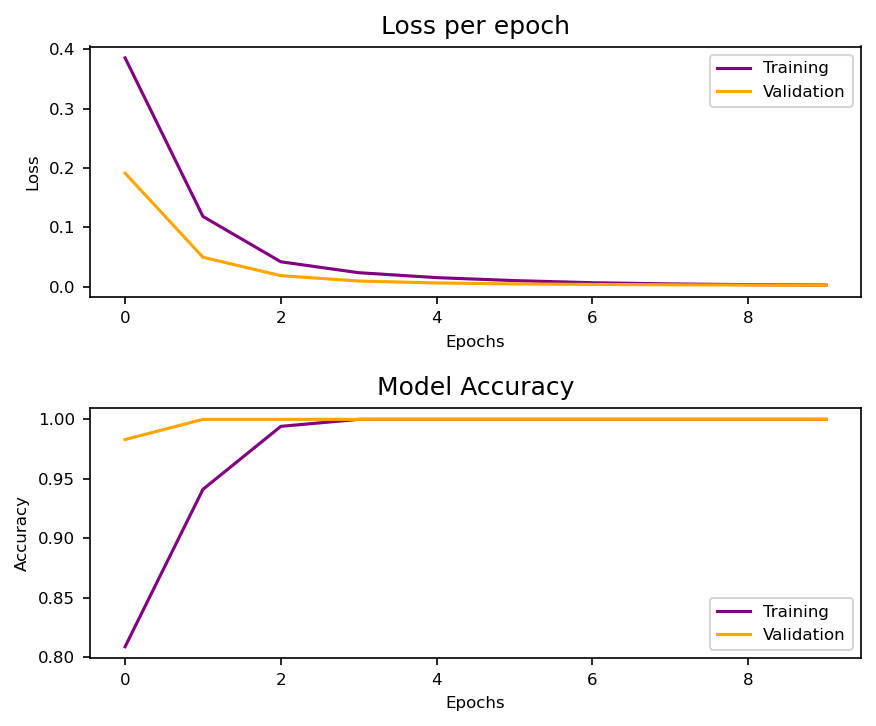

In [29]:
plot(num_epochs=10, loss_per_epoch= info['Loss']['ReLU'], loss_per_epoch_val = info['Loss_Val']['ReLU'], train_acc_per_epoch=info['Training_Accuracy']['ReLU'], valid_acc_per_epoch=info['Validation_Accuracy']['ReLU'])
plt.savefig(f'RelU.png',bbox_inches='tight',dpi=150, format='png')

## Test for different Activation functions

### MLP with Sigmoid 

In [30]:
# Architecture of Freedforward Neural Network for Sigmoid activation Function
from torch import nn
torch.manual_seed(seed)
np.random.seed(seed)
class MLP_sigmoid(nn.Module):
    def __init__(self,hid_layers_dim,input_dim,output_dim):
        'define layers and parameters of our network'
        super(MLP_sigmoid, self).__init__()
        #first hidden layer
        self.fc1=nn.Linear(input_dim,hid_layers_dim)
        self.act1=nn.Sigmoid()
        #second hidden layer
        self.fc2=nn.Linear(hid_layers_dim,hid_layers_dim)
        self.act2=nn.Sigmoid()
        
        self.output_layer=nn.Linear(hid_layers_dim,output_dim)
        #self.act_output=nn.Softmax(dim=1)
        
    def forward(self,x):
        'Executed every time we call the module'
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.output_layer(x)
       # x=self.act_output(x)
    
        return x

in_dim = dataset.shape[1] #input dims
n_h = 12 # neurons of hidden layer
n_o = 2 # output nodes
mlp_sigmoid=MLP_sigmoid(hid_layers_dim=n_h, input_dim=in_dim, output_dim= n_o )
result=mlp_sigmoid(data)
print(result.shape)

torch.Size([340, 2])


In [31]:
info['Loss']['Sigmoid'], info['Loss_Val']['Sigmoid'],info['Training_Accuracy']['Sigmoid'],info['Validation_Accuracy']['Sigmoid'] = model_train(MODEL=mlp_sigmoid, DATA_TRAIN=Data_loader, 
                                                                                                                 DATA_EVAL=Data_loader_val, LEARN_RATE=1e-3)

In [32]:
#plot(num_epochs=10, loss_per_epoch= info['Loss']['Sigmoid'], loss_per_epoch_val = info['Loss_Val']['Sigmoid'],train_acc_per_epoch=info['Training_Accuracy']['Sigmoid'], 
#     valid_acc_per_epoch=info['Validation_Accuracy']['Sigmoid'])

### MLP with Softmax

In [33]:
# Architecture of Freedforward Neural Network for Softmax activation Function
from torch import nn
torch.manual_seed(seed)
np.random.seed(seed)
class MLP_softmax(nn.Module):
    def __init__(self,hid_layers_dim,input_dim,output_dim):
        'define layers and parameters of our network'
        super(MLP_softmax, self).__init__()
        #first hidden layer
        self.fc1=nn.Linear(input_dim,hid_layers_dim)
        self.act1=nn.Softmax(dim=1)
        #second hidden layer
        self.fc2=nn.Linear(hid_layers_dim,hid_layers_dim)
        self.act2=nn.Softmax(dim=1)
        
        self.output_layer=nn.Linear(hid_layers_dim,output_dim)
        #self.act_output=nn.Softmax(dim=1)
        
    def forward(self,x):
        'Executed every time we call the module'
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.output_layer(x)
       # x=self.act_output(x)
    
        return x

in_dim = dataset.shape[1] #input dims
n_h = 12 # neurons of hidden layer
n_o = 2 # output nodes
mlp_softmax=MLP_softmax(hid_layers_dim=n_h, input_dim=in_dim, output_dim= n_o )
result=mlp_softmax(data)
print(result.shape)

torch.Size([340, 2])


In [34]:
info['Loss']['Softmax'],info['Loss_Val']['Softmax'], info['Training_Accuracy']['Softmax'], info['Validation_Accuracy']['Softmax'] = model_train(MODEL=mlp_softmax, DATA_TRAIN=Data_loader, 
                                                                                                                    DATA_EVAL=Data_loader_val, LEARN_RATE=1e-3)

In [35]:
#plot(num_epochs=10, loss_per_epoch= info['Loss']['Softmax'],loss_per_epoch_val = info['Loss_Val']['Softmax'], train_acc_per_epoch=info['Training_Accuracy']['Softmax'],
#     valid_acc_per_epoch=info['Validation_Accuracy']['Softmax'])

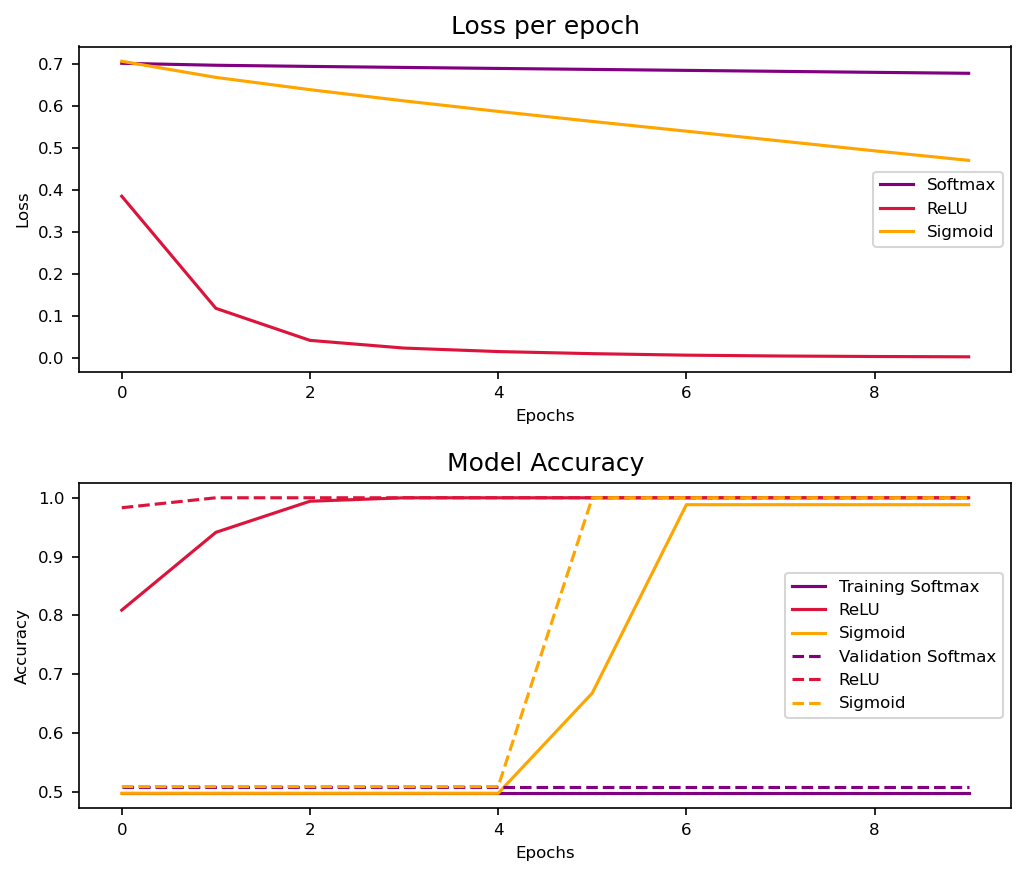

In [53]:
n_ep = np.arange(0,10 ,1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6))
ax1.plot(n_ep,info['Loss']['Softmax'], color = 'purple',label = 'Softmax' )
ax1.plot(n_ep,info['Loss']['ReLU'], color = 'crimson',label = 'ReLU' )
ax1.plot(n_ep,info['Loss']['Sigmoid'], color = 'orange',label = 'Sigmoid' )
ax1.set_title('Loss per epoch',fontsize=12)
ax1.set_xlabel('Epochs', fontsize=8)
ax1.set_ylabel('Loss', fontsize=8)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.legend(loc = 'center right', fontsize = 8)

ax2.plot(n_ep, info['Training_Accuracy']['Softmax'], color = 'purple',  label = 'Training Softmax')
ax2.plot(n_ep, info['Training_Accuracy']['ReLU'], color = 'crimson',  label = 'ReLU')
ax2.plot(n_ep, info['Training_Accuracy']['Sigmoid'], color = 'orange',  label = 'Sigmoid')
ax2.plot(n_ep, info['Validation_Accuracy']['Softmax'], color = 'purple', label = 'Validation Softmax', linestyle='--')
ax2.plot(n_ep, info['Validation_Accuracy']['ReLU'], color = 'crimson', label = 'ReLU', linestyle='--')
ax2.plot(n_ep, info['Validation_Accuracy']['Sigmoid'], color = 'orange', label = 'Sigmoid', linestyle='--')
#ax2.hlines(0.95,0,9,linestyle='dashed',color='red', label = '0.95 line')
ax2.set_title('Model Accuracy',fontsize=12)
ax2.xaxis.set_tick_params(labelsize=8)
ax2.yaxis.set_tick_params(labelsize=8)
ax2.set_xlabel('Epochs', fontsize=8)
ax2.set_ylabel('Accuracy', fontsize=8)
ax2.legend(loc = 'center right', fontsize = 8)

plt.tight_layout()
plt.savefig(f'DiffAct.png',bbox_inches='tight',dpi=150, format='png')

## Evaluate model with test data

In [37]:
#evaluate 
mlp.eval() 
mlp.to(device)
true_preds, num_preds = 0., 0.
pr_label= []
true_label= []
with torch.no_grad(): 
    
    for data_inputs, data_labels in Data_loader_test:

        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = mlp(data_inputs)
        preds = preds.squeeze(dim=1)
        
        pred_labels = torch.argmax(preds,1) 
        data_labels = torch.argmax(data_labels,1)
        #print(pred_labels)
        #print(data_labels)
        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]
        pr_label.append(pred_labels.numpy())     
        true_label.append(data_labels.numpy())
    
acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 95.38%


### Create confusion matrix

In [38]:
true = np.concatenate((true_label[0],true_label[1],true_label[2]))
pred = np.concatenate((pr_label[0],pr_label[1],pr_label[2]))

In [61]:
outcome = [] 
wrong = [] 
for i, item in enumerate(true):
    if item == pred[i]:
        outcome.append('True')
    else:
        outcome.append('False')
        wrong.append(i)
print(outcome)        
#print(len(outcome))


['True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'False', 'False', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True', 'True']


[36, 37, 38]

### Create composite of missclassified events

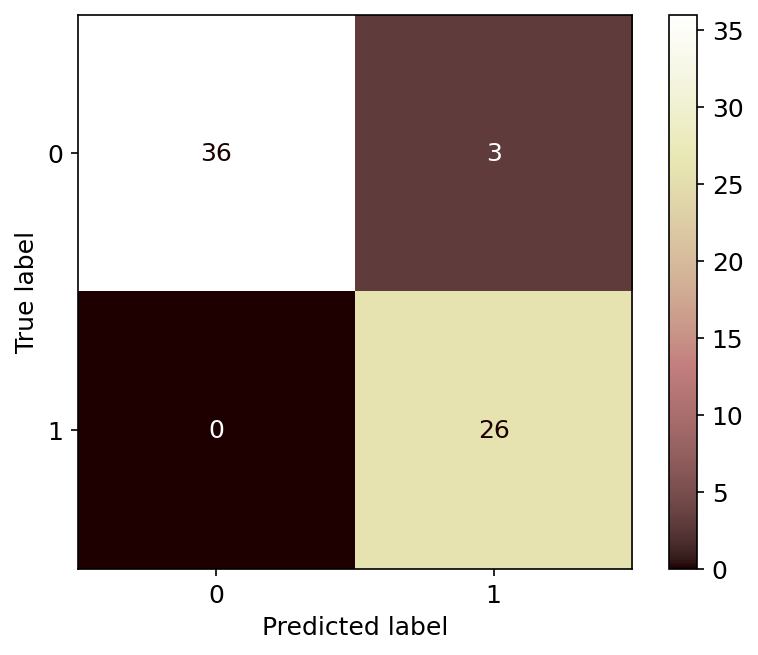

In [40]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(true, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot(cmap='pink')

plt.savefig(f'ConfMatrix.png',bbox_inches='tight',dpi=150, format='png')
#plt.show()

In [41]:
import pandas as pd 
df = pd.DataFrame(columns=['Actual Classification', 'Predicted Classification', 'Result'])
df['Actual Classification'] = true
df['Predicted Classification'] = pred 
df['Result'] = outcome
df

,Actual Classification,Predicted Classification,Result
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
60,0,0,True
61,0,0,True
62,0,0,True
63,0,0,True


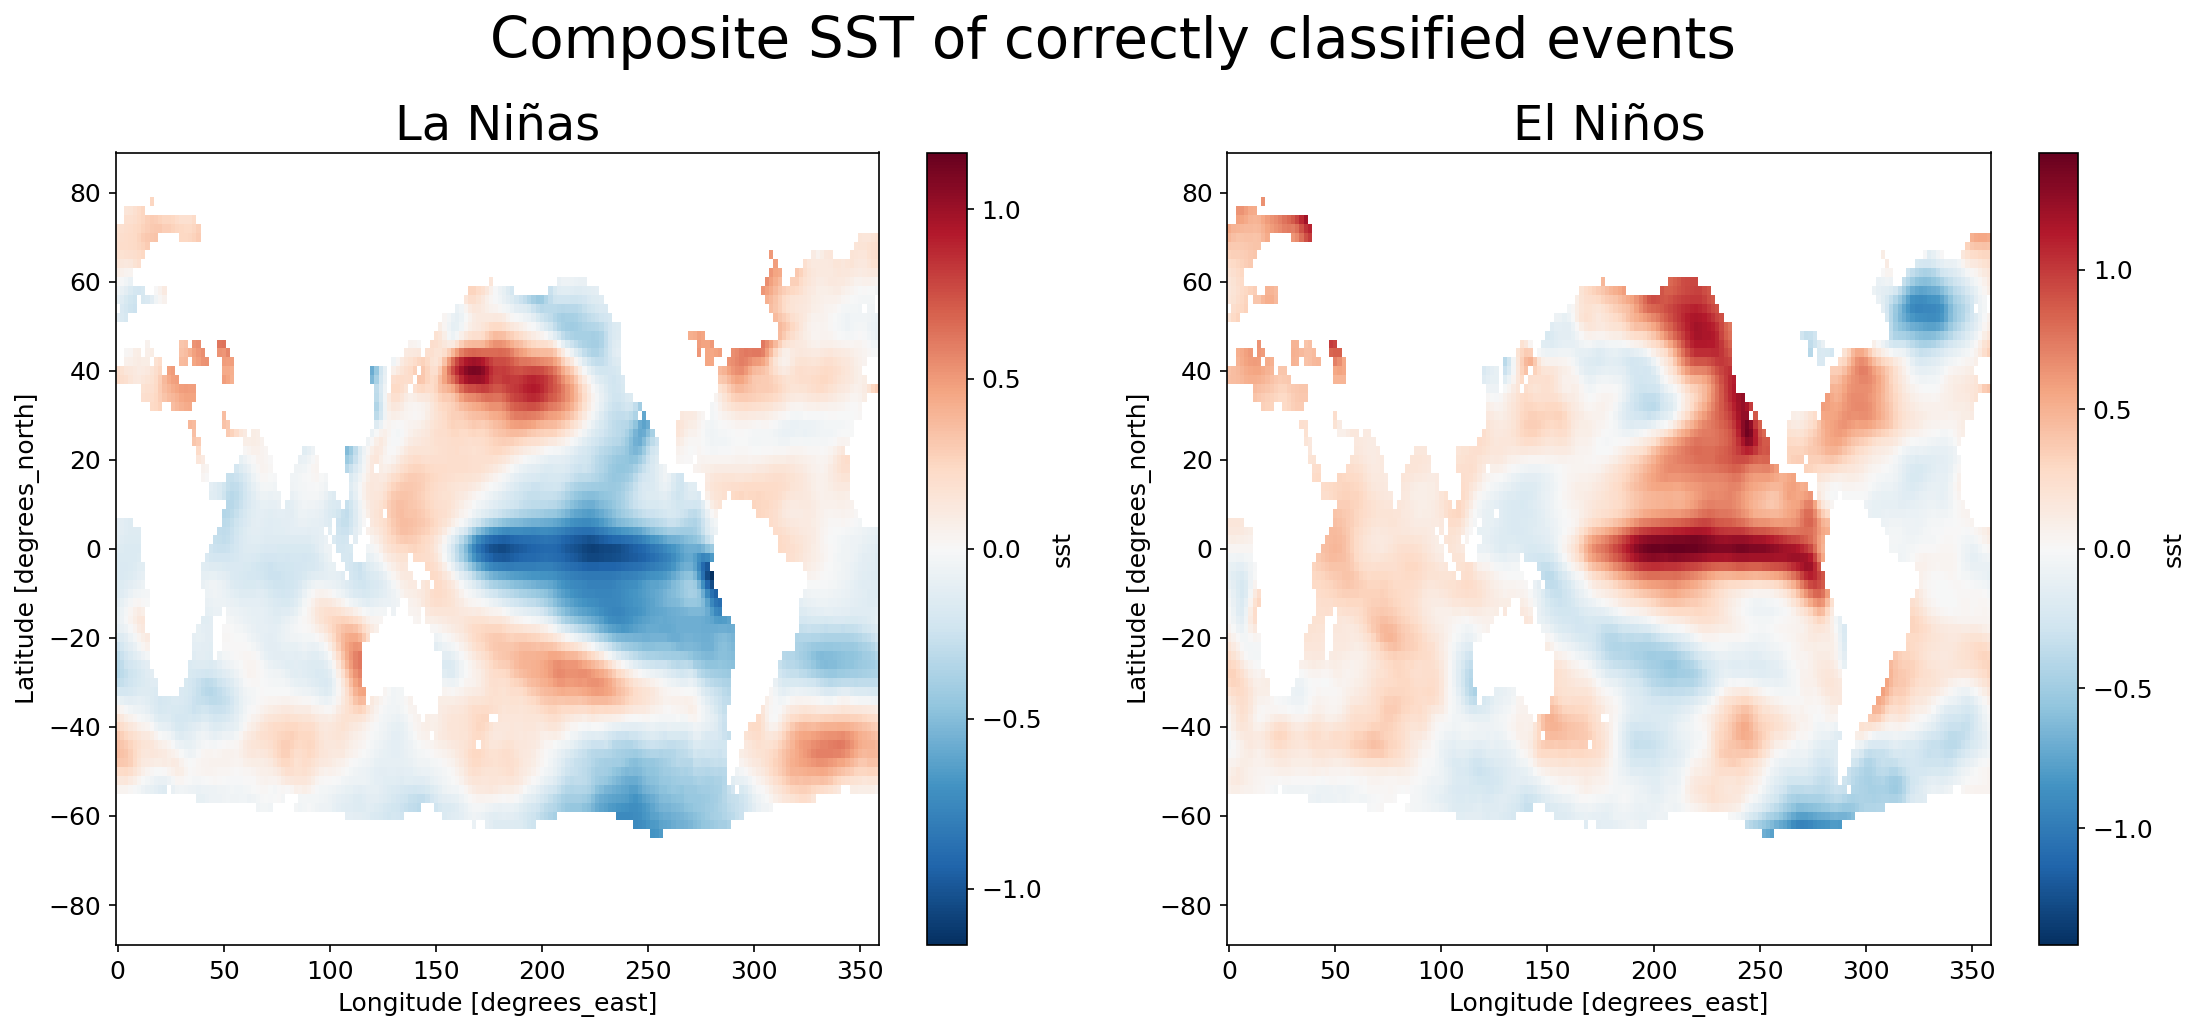

In [106]:
fig, (ax1,ax2) = plt.subplots(1,2 ,figsize=(15,7))
plt.suptitle("Composite SST of correctly classified events",  fontsize=27)
#plot composits of real laninas 
laNina_i= df[(df['Actual Classification']==0) & (df['Result']=='True')].index #index of real laninas 
real_laninas= testing.where(testing['class'][laNina_i] == 0, drop=True)
real_laninas['sst'].mean(dim='time').plot(ax=ax1)
ax1.set_title("La Niñas",  fontsize=23)
#plot composite of real elninos
elNino_i= df[(df['Actual Classification']==1) & (df['Result']=='True')].index
real_elninos= testing.where(testing['class'][elNino_i] == 1, drop=True)
real_elninos['sst'].mean(dim='time').plot(ax=ax2)
ax2.set_title("El Niños", fontsize=23)
plt.tight_layout()

plt.savefig(f'CorrectComposit.png',bbox_inches='tight',dpi=150, format='png')

In [42]:
def missclass(TRUE,TESTING,WRONG):
    
    'This function identified if El Ninos and/or Laninas where misclassified and creates composites for each phenomenon'
    
    testing =TESTING
    num_la = 0
    num_el = 0 
  
    for ind in WRONG:
        if TRUE[ind] == 0:
            num_la+= 1
        else:
            num_el+= 1
            
    if num_la>0 and num_el>0:
        Laninas = testing.where(testing['class'][wrong] == 0, drop=True)
        Elninos = testing.where(testing['class'][wrong] == 1, drop=True)
        
        plt.figure()
        plot = Laninas['sst'].mean(dim='time').plot()
        plt.title("Composite SST of Misclassified La Niñas")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.figure()
        plot = Elninos['sst'].mean(dim='time').plot()
        plt.title("Composite SST of missclassified El Niños")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(f'Composit.png',bbox_inches='tight',dpi=150, format='png')
       # plt.show() 
        
    elif num_la==0 and num_el>0:
        Elninos = testing.where(testing['class'][wrong] == 1, drop=True)
        
        Laninas = 'No missclassified La Ninas'
        
        plot = Elninos['sst'].mean(dim='time').plot()
        plt.title("Composite SST of misclassified El Niños")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(f'Composit.png',bbox_inches='tight',dpi=150, format='png')
        #plt.show()
    
    elif num_el==0 and num_la>0:
        Laninas = testing.where(testing['class'][wrong] == 0, drop=True)
        
        Elninos = 'No missclassified El Ninos'

        plot = Laninas['sst'].mean(dim='time').plot()
        plt.title("Composite SST of misclassified La Niñas")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.savefig(f'Composit.png',bbox_inches='tight',dpi=150, format='png')
       # plt.show()

    return Elninos, Laninas
            

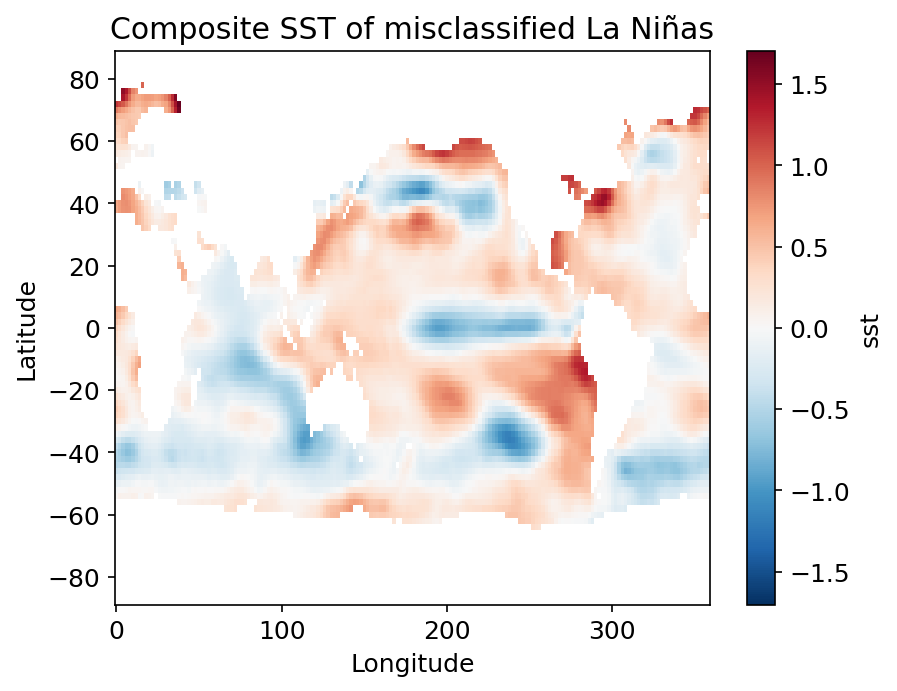

In [43]:
Elninos, Laninas = missclass(TRUE=true,TESTING=testing,WRONG=wrong)
#plt.savefig(f'Composit.png',bbox_inches='tight',dpi=150, format='png')

In [44]:
Laninas

<xarray.Dataset> Size: 387kB
Dimensions:  (time: 3, lat: 89, lon: 180)
Coordinates:
  * time     (time) object 24B 2017-01-15 00:00:00 ... 2017-03-15 00:00:00
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float64 384kB nan nan nan nan ... nan nan nan nan
    timevec  (time) float64 24B 2.017e+03 2.017e+03 2.017e+03
    nino34   (time) float64 24B -0.6441 -0.6304 -0.5432
    class    (time) float64 24B 0.0 0.0 0.0

## Study the effect of the Learning Rate on the training error

In [45]:
#log = np.logspace(-5, -3, 4)
log = [1e-2, 1e-3,1e-4,1e-5,]
log[0]
for i in range(len(log)):
    print(log[i])

0.01
0.001
0.0001
1e-05


0.342484667024771 0.0007084865310595934 η = 0.01
0.38553167473186145 0.002551460487500828 η = 0.001
0.6293283213268627 0.1185679090293971 η = 0.0001
0.6971931457519531 0.49867381290955975 η = 1e-05


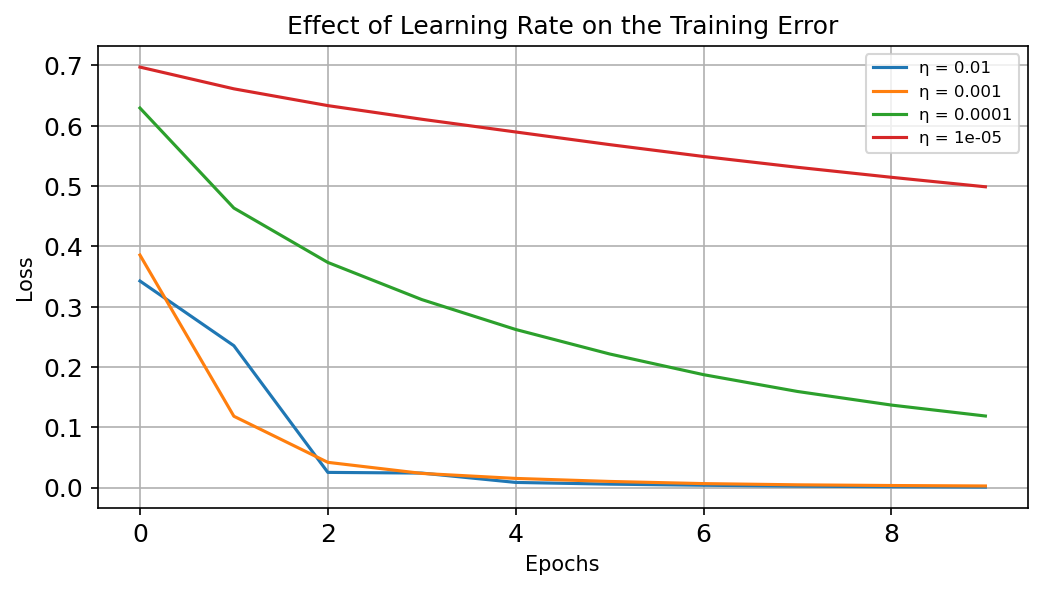

In [57]:
Loss =[]
epochs = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(8,4))
plt.title('Effect of Learning Rate on the Training Error',fontsize =12 )
plt.xlabel('Epochs',fontsize =10)
plt.ylabel('Loss',fontsize =10)
maxim=[]
minim=[]
#plt.yscale('log')
for i in range(len(log)):
    torch.manual_seed(seed)                 # CPU seed
    torch.cuda.manual_seed(seed)            # GPU seed (if using CUDA)
    torch.cuda.manual_seed_all(seed)        # all GPUs
    np.random.seed(seed)                     # NumPy seed
    random.seed(seed)
    mlp=MLP(hid_layers_dim=n_h, input_dim=in_dim, output_dim= n_o )
    loss, loos_val , train, val = model_train(MODEL=mlp, DATA_TRAIN=Data_loader, DATA_EVAL=Data_loader_val, LEARN_RATE=log[i])
    Loss.append(loss)
    plt.plot(epochs,loss, label = f'η = {log[i]}')
    plt.grid(True)
    plt.legend(loc='upper right', fontsize =8)
    maxim.append(max(loss))
    minim.append(min(loss))
    
    print(maxim[i], minim[i], f'η = {log[i]}')

plt.savefig(f'LearningRate.png',bbox_inches='tight',dpi=150, format='png')